# TP4-1 :  auto-encodeurs variationnels

In [ ]:
nom='jai'
prenom='ilyass'

In [1]:
import torch
use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
print(f"Exécution sur {device}")

Exécution sur cuda:0


In [2]:
# Imports des bibliothèques utiles
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt

In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST

from torchvision.transforms import ToTensor, ToPILImage

train_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=True, transform=ToTensor())
test_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=False, transform=ToTensor())

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.0MB/s]


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 174kB/s]


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.19MB/s]


Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.82MB/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



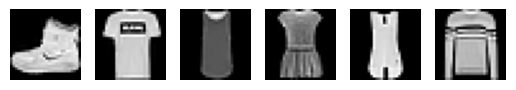

In [4]:
n_images = 5

fig = plt.figure()
for i, (image, label) in enumerate(train_dataset):
    fig.add_subplot(1, n_images+1, i+1)
    plt.imshow(ToPILImage()(image), cmap="gray")
    plt.axis("off")
    if i >= n_images:
        break
plt.show()

In [5]:
import torch
import torch.nn as nn

class AutoEncoder(nn.Module):
    def __init__(self, latent_dimension):
        super(AutoEncoder, self).__init__()

        # Encodeur
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        # Couche linéaire de l'encodeur
        self.encoder_fc = nn.Linear(in_features=64 * 7 * 7, out_features=latent_dimension)

        # Couche linéaire du décodeur
        self.decoder_fc = nn.Linear(in_features=latent_dimension, out_features=64 * 7 * 7)

        # Décodeur
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encodeur
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Aplatir pour la couche linéaire
        z = self.encoder_fc(x)  # Obtenir le vecteur latent

        # Décodeur
        x = self.decoder_fc(z)  # Repasser par la couche linéaire
        x = x.view(x.size(0), 64, 7, 7)  # Reshaper pour les couches de convolution transposée
        hat_x = self.decoder(x)  # Reconstruire l'image

        return hat_x, z

* Le modèle prend en entrée un batch d'images , encode ces images dans un vecteur latent, puis les reconstruit à travers le décodeur. La méthode forward renvoie à la fois la reconstruction (hat_x) et le vecteur latent (z).

In [6]:
from tqdm.notebook import trange, tqdm

def train(net, train_dataset, epochs=10, learning_rate=1e-3, batch_size=128, device=device):
    # Création du DataLoader pour charger les données
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    # Définition de l'algorithme d'optimisation (Adam, variante de la SGD)
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=1e-5)
    # Choix de la fonction de coût
    criterion = nn.MSELoss()
    # Passe le modèle en mode "apprentissage"
    net = net.to(device)
    net = net.train()

    train_loss_avg = []

    t = trange(1, epochs + 1, desc="Entraînement du modèle")
    for epoch in t:
        avg_loss = 0.
        # Parcours du dataset pour une epoch
        for images, _ in tqdm(train_dataloader):
            # les labels sont ignorés pour l'apprentissage de l'auto-encodeur

            images = images.to(device)
            # Calcul de la reconstruction
            reconstructions, _ = net(images)
            # Calcul del'erreur
            loss = criterion(reconstructions, images)

            # Rétropropagation du gradient
            optimizer.zero_grad()
            loss.backward()
            # Descente de gradient (une itération)
            optimizer.step()
            avg_loss += loss.item()

        avg_loss /= len(train_dataloader)
        t.set_description(f"Epoch {epoch}: loss = {avg_loss:.3f}")
    return net

In [7]:
latent_dimension = 10
net = AutoEncoder(latent_dimension)

In [8]:
net = train(net, train_dataset)

Entraînement du modèle:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

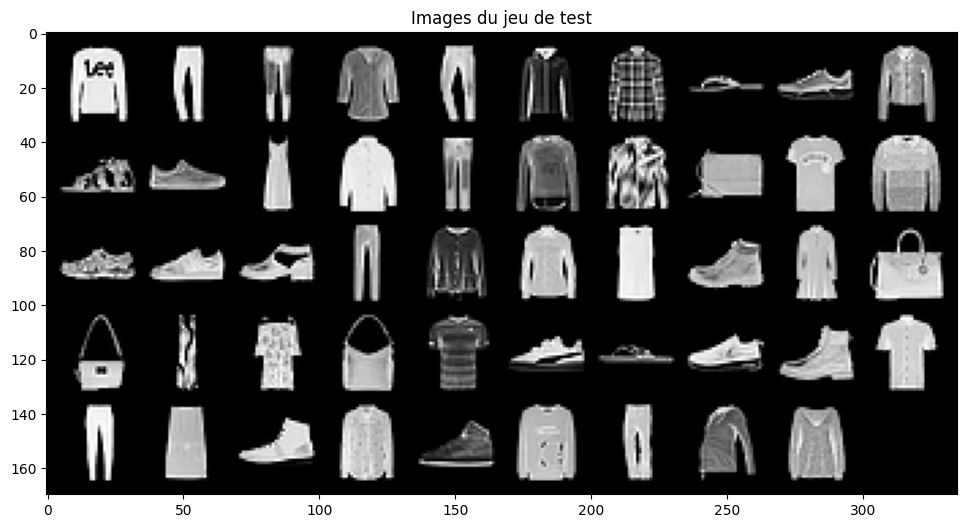

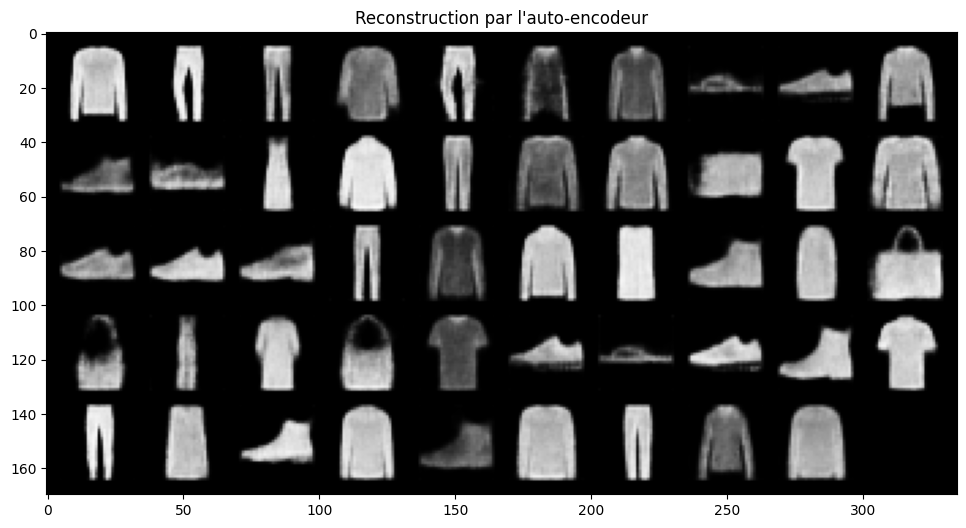

In [10]:
from torchvision.utils import make_grid

net = net.eval()
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)


def show_grid(grid):
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.show()

def visualize_reconstructions(net, images, device=device):
    # Mode inférence
    with torch.no_grad():
        images = images.to(device)
        reconstructions = net(images)[0]
        image_grid = make_grid(reconstructions[1:50], 10, 5).cpu()
        return image_grid

images, _ = next(iter(test_dataloader)) #next() instead of .next()

# Images de test
plt.figure(figsize=(12, 6))
plt.title("Images du jeu de test")
show_grid(make_grid(images[1:50],10,5))

# Reconstruction et visualisation des images reconstruites
plt.figure(figsize=(12, 6))
plt.title("Reconstruction par l'auto-encodeur")
show_grid(visualize_reconstructions(net, images))

### debruitage

In [11]:
noise_amplitude = 0.1  # Amplitude du bruit
noise = torch.rand_like(images) * noise_amplitude - (noise_amplitude / 2)  # Bruit uniforme centré à 0
noisy_images = torch.clamp(images + noise, 0, 1)  # Ajouter le bruit et limiter à [0, 1]


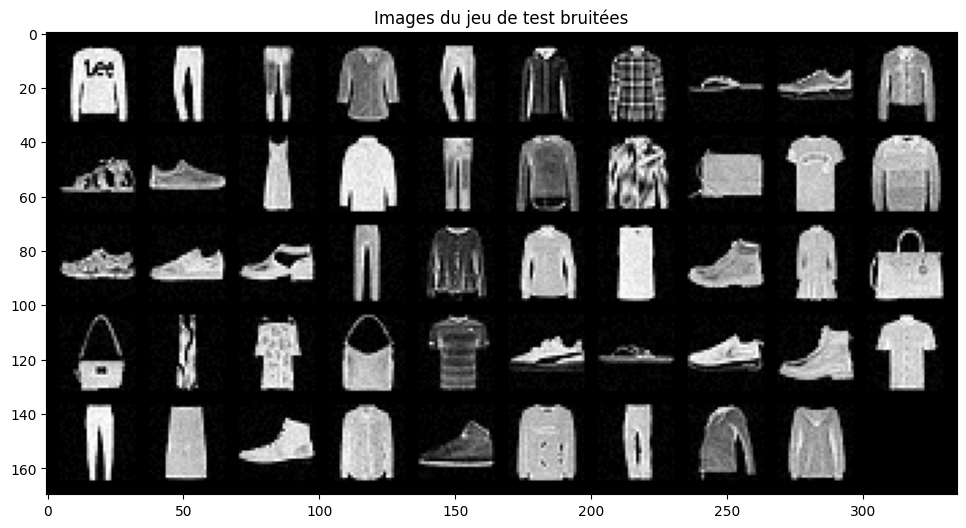

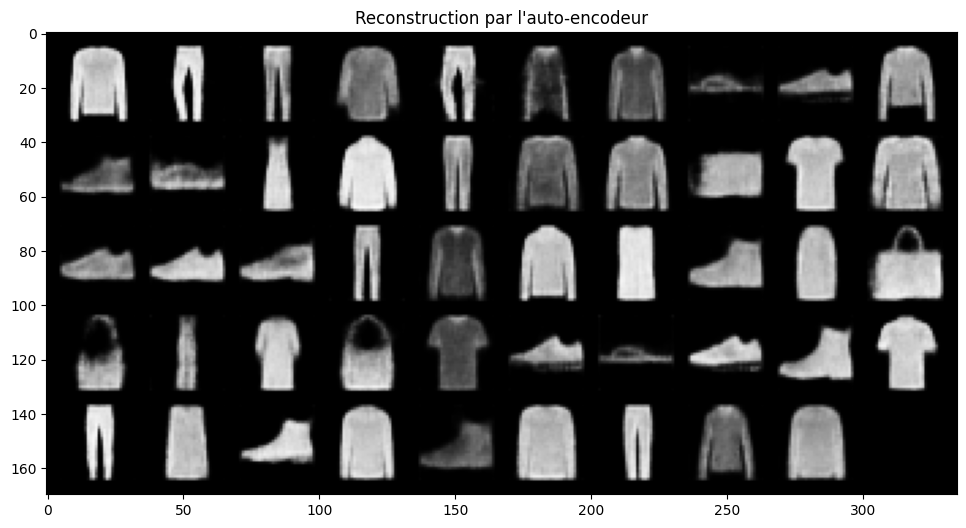

In [12]:
# Images de test
plt.figure(figsize=(12, 6))
plt.title("Images du jeu de test bruitées")
show_grid(make_grid(noisy_images[1:50],10,5))

# Reconstruction et visualisation des images reconstruites
plt.figure(figsize=(12, 6))
plt.title("Reconstruction par l'auto-encodeur")
show_grid(visualize_reconstructions(net, noisy_images))

* Reconstructions à partir des images originales :

Les reconstructions semblent plus nettes et plus proches des images originales.
Les détails importants des images, comme les contours des vêtements ou des objets, sont bien préservés.

* Reconstructions à partir des images bruitées :

Les reconstructions sont plus floues ou dégradées.
, surtout dans les zones contenant des détails fins.

ici j'ai essayé ici de calculer le MSE entre les images reconstruites par l'auto-encodeur (brutes et bruitées).

MSE des reconstructions (images originales) : 0.1637
MSE des reconstructions (images bruitées) : 0.1637


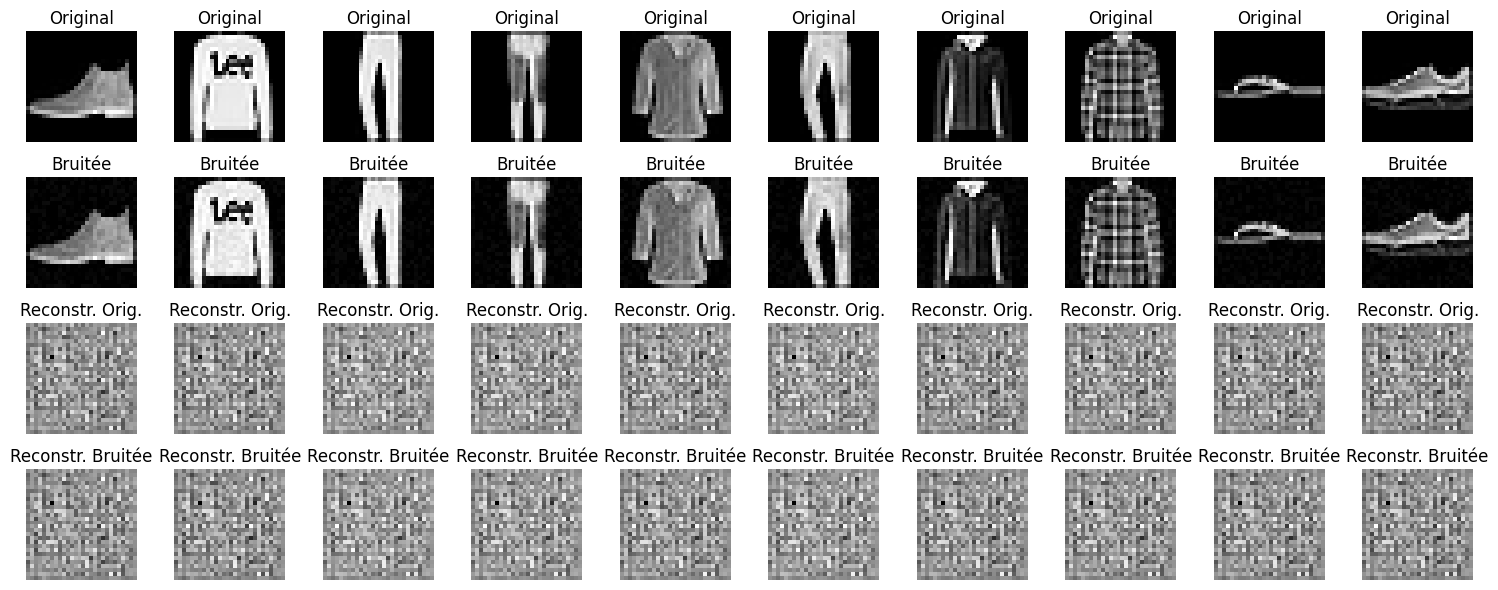

In [17]:
images = images.to(device)  # Déplacer les images originales
noisy_images = noisy_images.to(device)
net = AutoEncoder(latent_dimension).to(device)

# Reconstructions
with torch.no_grad():
    reconstructed_original, _ = net(images)
    reconstructed_noisy, _ = net(noisy_images)

# Calcul de l'erreur quadratique moyenne (MSE)
def compute_mse(original, reconstructed):
    return torch.mean((original - reconstructed) ** 2).item()

mse_original = compute_mse(images, reconstructed_original)
mse_noisy = compute_mse(images, reconstructed_noisy)

print(f"MSE des reconstructions (images originales) : {mse_original:.4f}")
print(f"MSE des reconstructions (images bruitées) : {mse_noisy:.4f}")

# Visualisation
def plot_comparison(original_images, noisy_images, reconstructed_original, reconstructed_noisy, num_images=10):
    fig, axes = plt.subplots(4, num_images, figsize=(15, 6))

    for i in range(num_images):
        axes[0, i].imshow(original_images[i].squeeze().cpu().numpy(), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")

        axes[1, i].imshow(noisy_images[i].squeeze().cpu().numpy(), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title("Bruitée")

        axes[2, i].imshow(reconstructed_original[i].squeeze().cpu().detach().numpy(), cmap='gray')
        axes[2, i].axis('off')
        axes[2, i].set_title("Reconstr. Orig.")

        axes[3, i].imshow(reconstructed_noisy[i].squeeze().cpu().detach().numpy(), cmap='gray')
        axes[3, i].axis('off')
        axes[3, i].set_title("Reconstr. Bruitée")

    plt.tight_layout()
    plt.show()

plot_comparison(images, noisy_images, reconstructed_original, reconstructed_noisy)

In [19]:
class Encoder(nn.Module):
    def __init__(self, latent_dimension):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(in_features=64 * 7 * 7, out_features=latent_dimension)
        self.fc_logvar = nn.Linear(in_features=64 * 7 * 7, out_features=latent_dimension)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Aplatir pour les couches linéaires
        x_mu = self.fc_mu(x)  # Moyennes
        x_logvar = self.fc_logvar(x)  # Log-variances
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self, latent_dimension):
        super(Decoder, self).__init__()
        self.decoder_fc = nn.Linear(in_features=latent_dimension, out_features=64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.decoder_fc(z)  # Repasser par la couche linéaire
        x = x.view(x.size(0), 64, 7, 7)  # Reshaper pour les couches de convolution transposée
        hat_x = self.decoder(x)  # Reconstruire l'image
        return hat_x


In [20]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, latent_dimension):
        super(VariationalAutoEncoder, self).__init__()
        self.encoder = Encoder(latent_dimension)
        self.decoder = Decoder(latent_dimension)

    def latent_sample(self, mu, logvar):
        # Reparamétrisation : z = mu + eps * sigma
        std = torch.exp(0.5 * logvar)  # Calculer l'écart-type
        eps = torch.randn_like(std)  # Échantillonner de N(0, 1)
        return mu + eps * std

    def forward(self, x):
        # Encodeur
        mu, logvar = self.encoder(x)
        # Échantillonner dans l'espace latent
        z = self.latent_sample(mu, logvar)
        # Décodeur
        x_recon = self.decoder(z)
        return x_recon, mu, logvar


In [21]:
# Fonction de coût du VAE
beta = 1.0

def vae_loss(hat_x, x, mu, logvar):
    # Reconstruction loss (Binary Cross-Entropy)
    reconstruction_loss = F.binary_cross_entropy(hat_x.view(-1, 28 * 28), x.view(-1, 28 * 28), reduction='sum')
    # KL Divergence
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Total loss
    return reconstruction_loss + beta * kl_divergence


In [22]:
from tqdm.notebook import trange, tqdm

def train_vae(net, train_dataset, epochs=10, learning_rate=1e-3, batch_size=128, device=device):
    # Création du DataLoader pour charger les données
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # Définition de l'algorithme d'optimisation (Adam, variante de la SGD)
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=1e-5)
    # Choix de la fonction de coût
    criterion = vae_loss
    # Passe le modèle en mode "apprentissage"
    net = net.to(device)
    net = net.train()

    t = trange(1, epochs + 1, desc="Entraînement du modèle")
    for epoch in t:
        avg_loss = 0.
        # Parcours du dataset pour une epoch
        for images, _ in tqdm(train_dataloader):
            # les labels sont ignorés pour l'apprentissage de l'auto-encodeur

            images = images.to(device)
            # Calcul de la reconstruction
            reconstructions, latent_mu, latent_logvar = net(images)
            # Calcul de l'erreur
            loss = criterion(reconstructions, images, latent_mu, latent_logvar)

            # Rétropropagation du gradient
            optimizer.zero_grad()
            loss.backward()
            # Descente de gradient (une itération)
            optimizer.step()
            avg_loss += loss.item()

        avg_loss /= len(train_dataloader)
        t.set_description(f"Epoch {epoch}: loss = {avg_loss:.3f}")
    return net.to("cpu")

In [23]:
vae = VariationalAutoEncoder(latent_dimension=latent_dimension)

In [24]:
trained_vae = train_vae(vae, train_dataset)

Entraînement du modèle:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

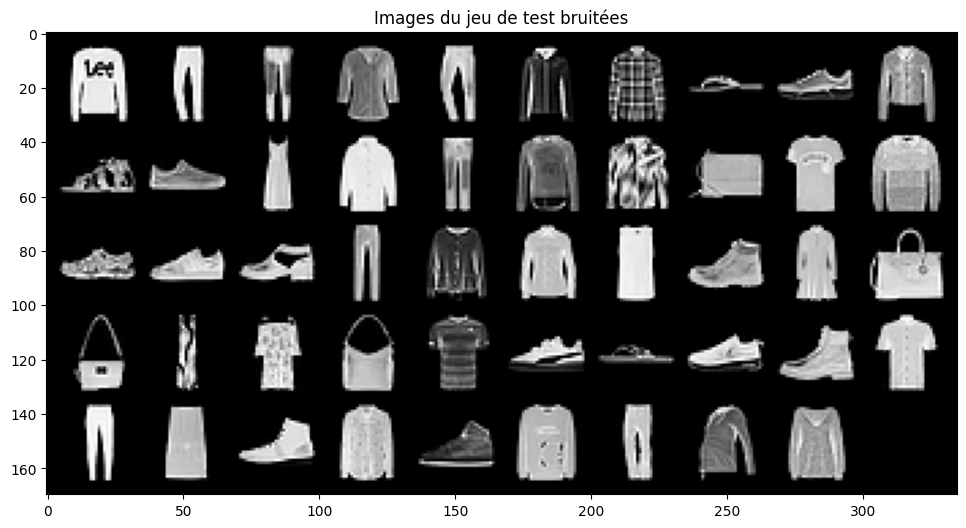

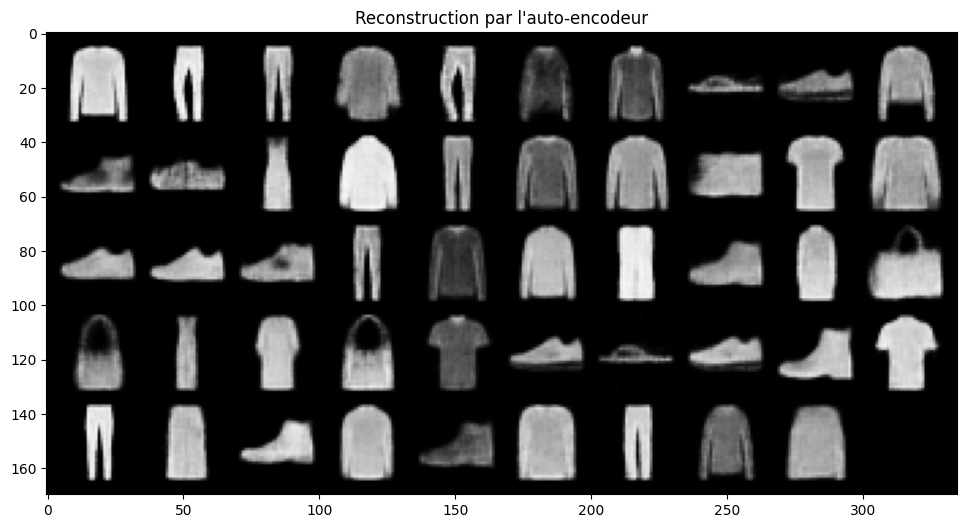

In [27]:
vae = vae.to(device)
images, _ = next(iter(test_dataloader)) # next()

# Images de test
plt.figure(figsize=(12, 6))
plt.title("Images du jeu de test bruitées")
show_grid(make_grid(images[1:50],10,5))

# Reconstruction et visualisation des images reconstruites
plt.figure(figsize=(12, 6))
plt.title("Reconstruction par l'auto-encodeur")
show_grid(visualize_reconstructions(vae, images))

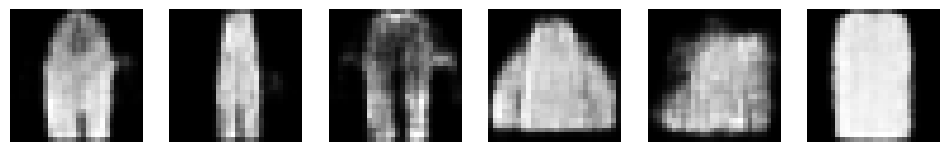

In [34]:

# Génération de nouvelles images
num_samples = 6
latent_samples = torch.randn(num_samples, latent_dimension).to(trained_vae.decoder.decoder_fc.weight.device)  # Échantillonne dans l'espace latent
with torch.no_grad():
    generated_images = trained_vae.decoder(latent_samples)  # Décode les vecteurs latents


fig, axes = plt.subplots(1, num_samples, figsize=(12, 6))
fig.subplots_adjust(wspace=0.2, hspace=0.2)

for i, ax in enumerate(axes):
    ax.imshow(generated_images[i].squeeze().cpu().numpy(), cmap='gray')
    ax.axis('off')
plt.show()


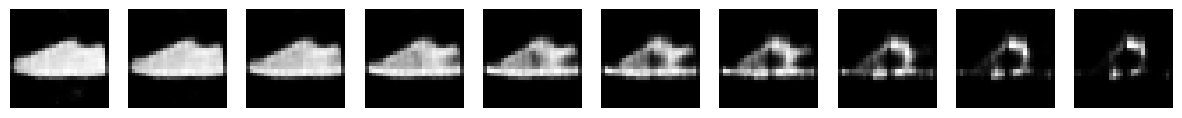

In [35]:
# Interpolation dans l'espace latent
num_interpolations = 10
z1 = torch.randn(1, latent_dimension).to(trained_vae.decoder.decoder_fc.weight.device)
z2 = torch.randn(1, latent_dimension).to(trained_vae.decoder.decoder_fc.weight.device)

interpolated_z = torch.stack([z1 * (1 - alpha) + z2 * alpha for alpha in torch.linspace(0, 1, steps=num_interpolations)])

with torch.no_grad():
  interpolated_images = trained_vae.decoder(interpolated_z)


fig, axes = plt.subplots(1, num_interpolations, figsize=(15, 3))
for i, ax in enumerate(axes):
  ax.imshow(interpolated_images[i].squeeze().cpu().numpy(), cmap='gray')
  ax.axis('off')
plt.show()


L'interpolation  montre une transition fluide entre deux objets dans l'espace latent du VAE
et le fait que chaque étape d'interpolation génère une image réaliste  indique que l'espace latent est bien organisé.
Cela résulte de la régularisation imposée par le terme KL-divergence, qui force les vecteurs latents à suivre une distribution normale standard.

cela montre qu on a pas des "trous" dans l'espace latent contrairement aux auto-encodeurs classiques.


100%|██████████| 26.4M/26.4M [00:02<00:00, 10.1MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 171kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.22MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.79MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



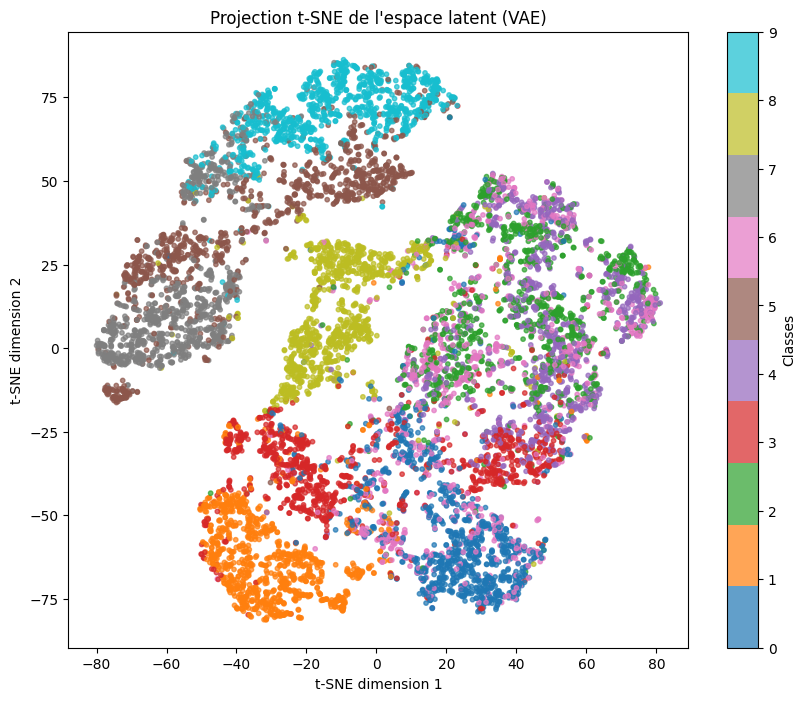

In [36]:
from sklearn.manifold import TSNE
# Récupération des codes latents et des étiquettes
vae = trained_vae  # Modèle entraîné précédemment
vae.eval()
vae.to(device)

latent_codes = []
labels = []

with torch.no_grad():
    for images, targets in test_dataloader:
        images = images.to(device)
        # Encode les images pour obtenir mu (moyenne)
        mu, _ = vae.encoder(images)
        latent_codes.append(mu.cpu())
        labels.append(targets)

latent_codes = torch.cat(latent_codes, dim=0).numpy()
labels = torch.cat(labels, dim=0).numpy()

# Réduction de dimension avec t-SNE
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_codes)

# Visualisation
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.7, s=10)
plt.colorbar(scatter, label='Classes')
plt.title("Projection t-SNE de l'espace latent (VAE)")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.show()
